In [1]:
import razor
import razor.flow as rf
from razor import api
from razor.flow.spark import SparkBlock, SparkExecutor


In [2]:
import os
from datetime import datetime, timedelta
from pyspark.sql import SparkSession, functions
from pyspark.sql.dataframe import DataFrame
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [3]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)


In [4]:
from pyspark.sql.functions import pandas_udf, PandasUDFType,collect_set

def get_customer_static_info(input_df):
    customer_static = input_df.select(["customer_name", "card_number", "card_type"])
    return customer_static

def get_merchant_static_info(input_df):
    merchant_static_temp = input_df.select(["merchant_id", "product_type"])
    merchant_static_data = input_df.select(["merchant_id", "merchant_city", "merchant_state"])
    merchant_static_temp = merchant_static_temp.groupBy("merchant_id").agg(collect_set("product_type").alias("list_of_product"))
    merchant_static = merchant_static_data.join(merchant_static_temp, on='merchant_id', how='left')
    return merchant_static


In [5]:
@rf.block
class NonSparkPath:
    
#     __publish__ = True
#     __label__ = "Spark read csv block"
#     __description__ = "Read a csv file from project space and output as a spark dataframe"
#     __tags__ = ["spark", "filter", "big data","csv","projectspace"]
#     __category__ = "Spark"
#     __technology__ = razor.Technology.SPARK
    
    # Atomic input - csv filename relative to project space
    ip_path: str
    # Atomic output of type spark DataFrame.
    op_path: rf.Output[str]
    
    def run(self):
        self.op_path.put(project_space_path(self.ip_path))
        

In [6]:
nsp = NonSparkPath(ip_path='customer_data.csv')

In [7]:
nsp.execute()

{'op_path': '/home/aios/projectspace/customer_data.csv'}

In [8]:
@rf.block
class ReadCsvProjectSpace(SparkBlock):
    
#     __publish__ = True
#     __label__ = "Spark read csv block"
#     __description__ = "Read a csv file from project space and output as a spark dataframe"
#     __tags__ = ["spark", "filter", "big data","csv","projectspace"]
#     __category__ = "Spark"
#     __technology__ = razor.Technology.SPARK
    
    # Atomic input - csv filename relative to project space
    filename:str
    # Atomic output of type spark DataFrame.
    data: rf.Output[DataFrame]
    
    def run(self):
        df = self.spark.read.csv(self.filename, header = True)
        print("Hello")
        df.printSchema()
        self.data.put(df)
        

In [9]:
rcp = ReadCsvProjectSpace(filename = nsp.op_path, config={}, source="")
rcp.executor = SparkExecutor

In [10]:
rcp.execute()

In [11]:
@rf.block
class RandomProcess1(SparkBlock):
    
#     __publish__ = True
#     __label__ = "Spark read csv block"
#     __description__ = "Read a csv file from project space and output as a spark dataframe"
#     __tags__ = ["spark", "filter", "big data","csv","projectspace"]
#     __category__ = "Spark"
#     __technology__ = razor.Technology.SPARK
    
    # Atomic input - csv filename relative to project space
    ip_data: DataFrame
    # Atomic output of type spark DataFrame.
    op_data: rf.Output[DataFrame]
    
    def run(self):
        customer_static = get_customer_static_info(self.ip_data)
        customer_static.show()
        self.op_data.put(customer_static)
        
        

In [12]:
rp1 = RandomProcess1(ip_data = rcp.data, config={}, source="")
rp1.executor = SparkExecutor

In [13]:
@rf.block
class DropDuplicates(SparkBlock):
    
#     __publish__ = True
#     __label__ = "Spark read csv block"
#     __description__ = "Read a csv file from project space and output as a spark dataframe"
#     __tags__ = ["spark", "filter", "big data","csv","projectspace"]
#     __category__ = "Spark"
#     __technology__ = razor.Technology.SPARK
    
    # Atomic input - csv filename relative to project space
    ip_data: DataFrame
    # Atomic output of type spark DataFrame.
    op_data: rf.Output[DataFrame]
    
    def run(self):
        ip_data = self.ip_data.dropDuplicates()
        self.op_data.put(ip_data)
        

In [14]:
drp = DropDuplicates(ip_data = rp1.op_data, config={}, source="")
drp.executor = SparkExecutor

In [15]:
@rf.block
class RandomProcess2(SparkBlock):
    
#     __publish__ = True
#     __label__ = "Spark read csv block"
#     __description__ = "Read a csv file from project space and output as a spark dataframe"
#     __tags__ = ["spark", "filter", "big data","csv","projectspace"]
#     __category__ = "Spark"
#     __technology__ = razor.Technology.SPARK
    
    # Atomic input - csv filename relative to project space
    ip_data: DataFrame
    # Atomic output of type spark DataFrame.
    op_data: rf.Output[DataFrame]
    
    def run(self):
        merchant_static = get_merchant_static_info(self.ip_data)
        merchant_static.show()
        self.op_data.put(merchant_static)
        
        

In [16]:
rp2 = RandomProcess2(ip_data = rcp.data, config={}, source="")
rp2.executor = SparkExecutor

In [17]:
pipe = rf.Pipeline(targets = [drp, rp2])

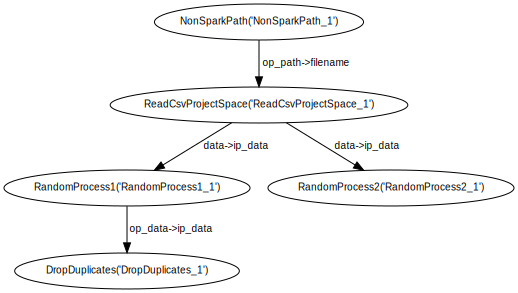

In [18]:
pipe

In [19]:
pipe.execute()

log path: /tmp/tmpx2sjv1rv/Pipeline_1


+-----------+--------------+--------------+--------------------+
|merchant_id| merchant_city|merchant_state|     list_of_product|
+-----------+--------------+--------------+--------------------+
|    1000758|       Hampton|      Kentucky|         [Groceries]|
|    1000711|        Galion|          Ohio|         [Groceries]|
|    1000950|   Charlestown|  Rhode Island|           [PetCare]|
|    1000860|            WJ|          Utah|         [Groceries]|
|    1000624|Pass Christian|   Mississippi|[Groceries, Furni...|
|    1001178|   Charlestown|  Rhode Island|[Groceries, PetCare]|
|    1001001| College Grove|     Tennessee|           [PetCare]|
|    1000677|       Kenmare|  North Dakota|[Groceries, Texti...|
|    1000729|      Danville|       Georgia|[Cinema, Shows an...|
|    1001096|     Pentwater|      Michigan|         [Groceries]|
|    1001096|     Pentwater|      Michigan|         [Groceries]|
|    1000853|        Jayton|         Texas|[Water, Electrici...|
|    1001148|       Newpo

{}